In [1]:
import os
import datetime

import sys

sys.path.append("..")

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from functions import df_security_code, missingValues

from sklearn.metrics import mean_squared_error

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Data

In [2]:
# TODO axis o is time dimension

In [3]:
data_train = pd.read_csv('../data/curr_train_data.csv', parse_dates=['Date'],  index_col=[0])
data_test = pd.read_csv('../data/curr_test_data.csv', parse_dates=['Date'],  index_col=[0])
df_train = df_security_code(data_train, 7616)
df_test = df_security_code(data_test, 7616)
del data_train, data_test

In [4]:
df_train.head(2)

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
2112813,20170509_7616,2017-05-09,7616,0.0,0,1868.0,1878.0,1864.0,1872.0,195000.0,...,5.0,2017.0,19.0,3.011912,-1.398000e+09,2.344440e+11,-0.596304,-29.21519,34.976078,-47.557515
2112814,20170510_7616,2017-05-10,7616,0.0,0,1888.0,1930.0,1881.0,1928.0,733300.0,...,5.0,2017.0,19.0,3.011912,-1.398000e+09,2.344440e+11,-0.596304,-29.21519,34.976078,-47.557515


In [5]:
df_test.head(2)

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
2113913,20211105_7616,2021-11-05,7616,0.0,0,1663.0,1677.0,1655.0,1676.0,315800.0,...,11.0,2021.0,44.0,1.527375,719000000.0,3.933000e+10,1.828121,0.0,0.0,0.0
2113914,20211108_7616,2021-11-08,7616,0.0,0,1687.0,1704.0,1681.0,1689.0,480600.0,...,11.0,2021.0,45.0,3.739111,719000000.0,3.933000e+10,1.828121,0.0,0.0,0.0


In [6]:
df_train.describe().T.head(30)

,count,mean,std,min,25%,50%,75%,max
SecuritiesCode,1100.0,7616.000000,0.000000,7616.000000,7616.000000,7616.000000,7616.000000,7.616000e+03
ExpectedDividend,1100.0,0.018182,0.301100,0.000000,0.000000,0.000000,0.000000,5.000000e+00
SupervisionFlag,1100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
ad_Open,1100.0,2117.578182,427.272953,1180.000000,1851.750000,2080.000000,2323.500000,3.185000e+03
ad_High,1100.0,2141.008182,427.363461,1209.000000,1876.750000,2102.000000,2345.500000,3.225000e+03
ad_Low,1100.0,2094.330000,427.728149,1162.000000,1827.750000,2060.000000,2302.000000,3.150000e+03
ad_Close,1100.0,2117.138182,427.114628,1179.000000,1853.750000,2083.000000,2324.500000,3.175000e+03
ad_Volume,1100.0,386650.181818,451013.873566,0.000000,166375.000000,237400.000000,420875.000000,7.485800e+06
ad_Target,1100.0,0.000103,0.021691,-0.105793,-0.009494,0.000851,0.009825,1.206268e-01
ad_Close_lag1,1100.0,2117.301818,426.967085,1179.000000,1854.750000,2083.000000,2324.500000,3.175000e+03


- transform date

In [7]:
def transform_date(df):
    date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m.%d')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24*60*60
    week = 7*day
    month = 30.4167*day
    year = (365.2425)*day

    df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    df['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    df['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))

    df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [8]:
transform_date(df_train)
transform_date(df_test)

# Preparation for modelling

## - Train Test Split


In [9]:
def split_train_val(df, split=22):
    l_train = len(df)
    df_train =  df[:- split]
    df_val = df[- split : ]
    return df_train, df_val

df_train, df_val = split_train_val(df_train)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1078, 62)
(22, 62)
(22, 62)


In [10]:
df_train.tail(2)

,RowId,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,...,margin,win_quarter_growth,rev_quarter_growth,margin_growth,Day_sin,Day_cos,Month_sin,Month_cos,Year_sin,Year_cos
2113889,20211001_7616,7616,0.0,0,1759.0,1766.0,1720.0,1766.0,950700.0,-0.002857,...,1.828121,0.0,0.0,0.0,-1.121614e-11,1.0,0.577271,-0.816552,-0.999987,-0.005150
2113890,20211004_7616,7616,0.0,0,1782.0,1789.0,1738.0,1750.0,1185600.0,-0.021777,...,1.828121,0.0,0.0,0.0,-1.287244e-11,1.0,-0.004328,-0.999991,-0.998921,0.046442


In [11]:
df_val.head(2)

,RowId,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,...,margin,win_quarter_growth,rev_quarter_growth,margin_growth,Day_sin,Day_cos,Month_sin,Month_cos,Year_sin,Year_cos
2113891,20211005_7616,7616,0.0,0,1748.0,1764.0,1728.0,1745.0,811400.0,-0.042179,...,1.828121,0.0,0.0,0.0,-8.573902e-12,1.0,-0.209338,-0.977843,-0.997974,0.063618
2113892,20211006_7616,7616,0.0,0,1738.0,1748.0,1700.0,1707.0,968600.0,0.032416,...,1.828121,0.0,0.0,0.0,-4.275363e-12,1.0,-0.405447,-0.914118,-0.996732,0.080776


In [12]:
missingValues(df_train)

,N_missing,Percentage


In [13]:
missingValues(df_val)

,N_missing,Percentage


In [14]:
missingValues(df_test)

,N_missing,Percentage


## - Scaling

In [15]:
feat_not_to_scale = ['RowId', 'SecuritiesCode']
feat_to_scale = [col for col in df_train.columns if col not in feat_not_to_scale]
len(feat_to_scale)

60

In [16]:
def scaling_df(df, feat_to_scale):

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[feat_to_scale])
    
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = feat_to_scale
    return df_scaled
        


In [17]:
df_train_scaled = scaling_df(df_train, feat_to_scale)
df_val_scaled = scaling_df(df_val, feat_to_scale)
df_test_scaled = scaling_df(df_test, feat_to_scale)

In [18]:
print(df_train_scaled.shape)
print(df_val_scaled.shape)
print(df_test_scaled.shape)


(1078, 60)
(22, 60)
(22, 60)


## - Window

In [19]:

# return the index of the column we want to predict
def col_index (df, target, test_cols=None):
    if test_cols: 
        df= df.loc[:,test_cols]
    column_indices = {name: i for i, name in
                           enumerate(df.columns)}
    return column_indices[target]

In [20]:
# 
def blocking_split(df, test_cols=None, windowsize=22, target = 'ad_Close'):
    """create the slices of the data"""
    if test_cols: 
        df= df.loc[:,test_cols]

    # create slices
    s_inputs = list()
    s_target = list()
    # iterate over observations
    for i in range(0, len(df)-windowsize):
        # slice inputs
        input = df.iloc[i:windowsize + i ,0:]
        s_inputs.append(input) 
        # slice target 
        target = df.iloc[windowsize + i,0:]
        s_target.append(target)

    return s_target, s_inputs

In [21]:
target_slices, input_slices = blocking_split(df_train_scaled)
assert len(target_slices) == len(input_slices)

In [22]:
target_index = col_index (df_train_scaled, 'ad_Close', test_cols=None)
target_index

5

In [23]:
def extract_target(target_slices, input_slices , target_index):
    # extract close:
    y_one = list()
    for i in range(0,len(target_slices)):
        # value for column target_index in i target
        y_one.append(target_slices[i][target_index])

    X_one = list()
    for i in range(0,len(input_slices)):
        X_one.append(input_slices[i].iloc[:,target_index])#[0])

    
    return y_one, X_one

In [24]:
target_index = col_index (df_train_scaled, 'ad_Close', test_cols=None)
y_one, x_one = extract_target(target_slices, input_slices, target_index)
assert len(y_one) == len(x_one)

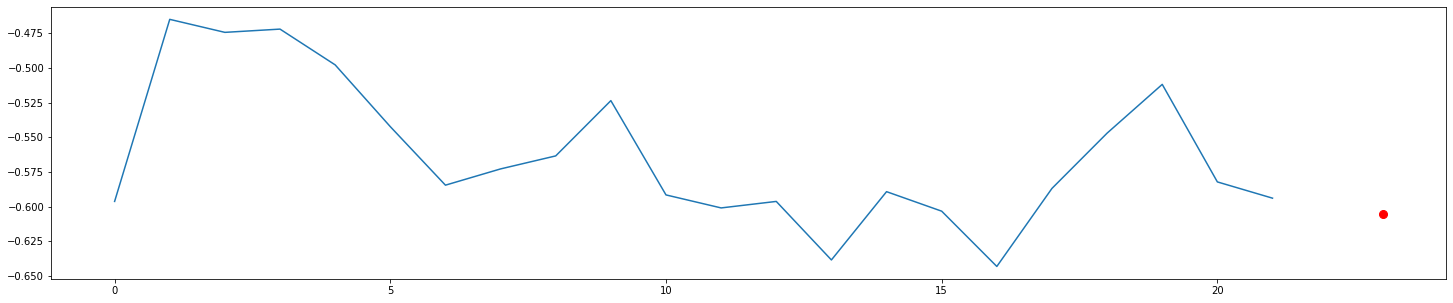

In [25]:

plt.figure(figsize=(25,5))
plt.plot(x_one[0])
plt.scatter((len(x_one[0])+1), y_one[0], color='red',s=64)

## Baseline model

In [26]:
X_array = np.array(input_slices)
y_array = np.array(target_slices)

In [27]:
def basline_array(X, y):
    assert len(X)== len(y)
    y_pred = np.array(pd.DataFrame(y).shift(1))
    return y_pred

def RSME_array(y_train, y_pred,target_index ):
    # rsme close
    mean = sum(y_train[1:,target_index]) / (len(y_train[1:,target_index]))
    rsme = mean_squared_error(y_pred=y_pred[1:,target_index], y_true=y_train[1:,target_index], squared=False)
    print(f'Mean: {mean:.4f}')
    print(f'rsme: {rsme:.4f}')
    print(f'rsme%: {rsme/mean*100:.2f}')
    return mean, rsme, rsme/mean

In [28]:
y_pred = basline_array(X_array, y_array)

a, b, c = RSME_array(y_array, y_pred, target_index)


Mean: 0.0123
rsme: 0.1014
rsme%: 823.82


In [29]:
X_stack = tf.stack(X_array) #example_window
y_stack = tf.stack(y_array) #example_window

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-27 15:24:38.680208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 15:24:38.680504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## - linear model

In [38]:
type(X_array)

numpy.ndarray

In [34]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [35]:
MAX_EPOCHS = 20

def compile_and_fit(model, X, y, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(X, epochs=MAX_EPOCHS,
                      validation_data=y,
                      callbacks=[early_stopping])
  return history

In [37]:
history = compile_and_fit(linear, X_array,y_array)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# - test

In [31]:
data = np.array(df_train_scaled, dtype=np.float32)
targets = np.array(df_val_scaled, dtype=np.float32)
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data, targets, sequence_length=total_window_size, 
    sequence_stride=1,
      shuffle=True,
      batch_size=32,)

#ds = ds.map(split_window)
type(ds)

NameError: name 'total_window_size' is not defined

In [ ]:
"""counter = 0 
for batch in ds:
  counter = counter +1
  print (batch)
  #print(batch)
  print(len(inputs))
  inputs, targets = batch
  #print(len(inputs))
  #assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
"""


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_scaled, val_df=val_scaled, test_df=test_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
train_scaled.shape

In [ ]:
w1 = WindowGenerator(input_width=22, label_width=1, shift=1,
                     label_columns=['ad_Close'])
w1

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
example_window = tf.stack([np.array(train_scaled[:w1.total_window_size]),
                           np.array(train_scaled[100:100+w1.total_window_size]),
                           np.array(train_scaled[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
type(example_inputs)

In [ ]:
example_labels

In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
w1.plot()

In [ ]:
w1.plot(plot_col='ad_Target')

- ## create dataset

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

## - train , val , test

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

## - single step models:
predict a single features value 1 time step into future

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ad_Close'])
single_step_window

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

- Baseline

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=w1.column_indices['ad_Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
#val_performance['Baseline'] = baseline.evaluate(w1.val_df)
#performance['Baseline'] = baseline.evaluate(w1.test_df, verbose=0)

In [ ]:
single_step_window.plot(baseline)

In [ ]:
wide_window = WindowGenerator(
    input_width=22, label_width=22, shift=1,
    label_columns=['ad_Close'])

wide_window

In [ ]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline)

## - linear

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, wide_window)

#val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(linear)

In [ ]:
plt.bar(x = range(len(train_scaled.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_scaled.columns)))
_ = axis.set_xticklabels(train_scaled.columns, rotation=90)

In [ ]:

#val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

In [ ]:
performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()